In [30]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.stats import mad_std
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import interp1d

import gary.coordinates as gc

## K2, Fields 8 and 10

Rough coordinates from [this plot](http://keplerscience.arc.nasa.gov/K2/images/Field8/field8-final.png).

In [78]:
field8_center = coord.SkyCoord(ra=16*u.deg, dec=5*u.deg)
_field8_pts = np.meshgrid(np.linspace(9, 23, 100),
                          np.linspace(-2, 12, 100))
field8_pts = coord.SkyCoord(ra=np.ravel(_field8_pts[0]) * u.deg, 
                            dec=np.ravel(_field8_pts[1]) * u.deg)

# ---
field10_center = coord.SkyCoord(ra=187.*u.deg, dec=-4*u.deg)
_field10_pts = np.meshgrid(np.linspace(180, 193, 100),
                           np.linspace(-11, 3, 100))
field10_pts = coord.SkyCoord(ra=np.ravel(_field10_pts[0]) * u.deg, 
                            dec=np.ravel(_field10_pts[1]) * u.deg)

## LM10 model of the Sgr stream

N-body stream model from [Law & Majewski (2010)](http://adsabs.harvard.edu/cgi-bin/nph-data_query?bibcode=2010ApJ...714..229L&db_key=AST&link_type=ABSTRACT&high=51a39ba3d713936).

Get it by uncommenting and running cell below:

In [3]:
# !wget http://scratch.adrian.pw/lm10.dat -P ../data/

In [4]:
lm10 = ascii.read("../data/lm10.dat")
print(lm10.colnames)

['Lambda', 'Beta', 'ra', 'dec', 'l', 'b', 'xgc', 'ygc', 'zgc', 'xsun', 'ysun', 'zsun', 'x4', 'y4', 'z4', 'u', 'v', 'w', 'dist', 'vgsr', 'mul', 'mub', 'mua', 'mud', 'Pcol', 'Lmflag']


In [5]:
lm10_coords = coord.SkyCoord(ra=lm10['ra']*u.deg, 
                             dec=lm10['dec']*u.deg)

In [79]:
lm10_sgr = lm10_coords.transform_to(gc.Sagittarius)
field8_sgr = field8_pts.transform_to(gc.Sagittarius)
field10_sgr = field10_pts.transform_to(gc.Sagittarius)

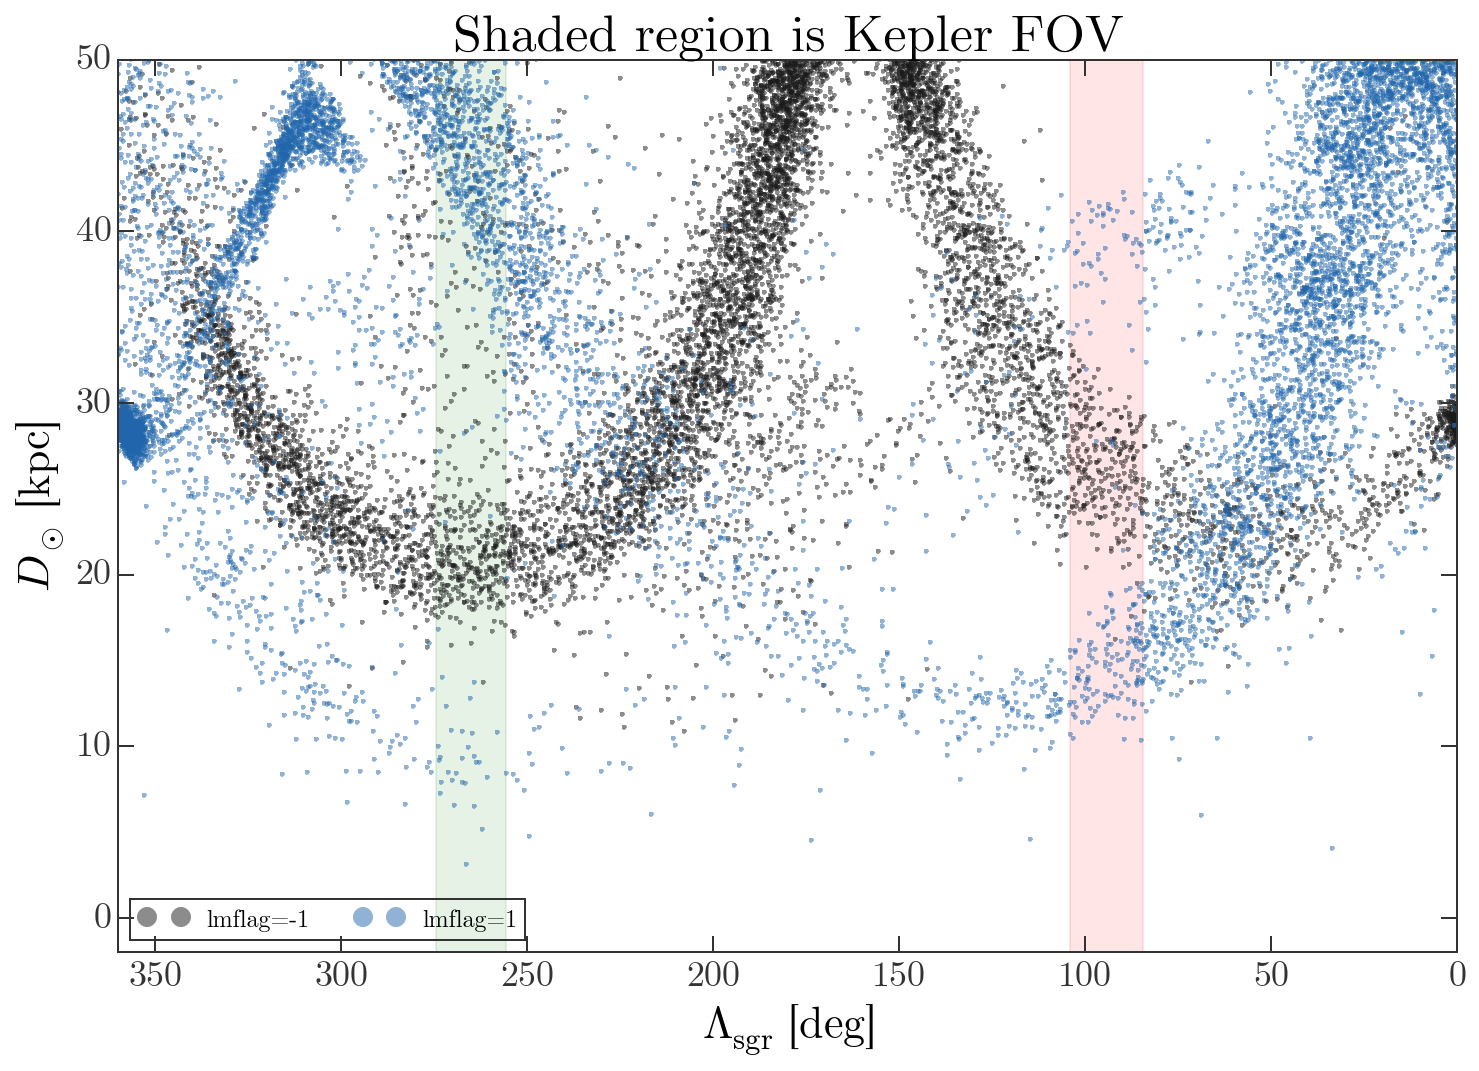

In [84]:
fig = plt.figure(figsize=(12,8))

plt.fill_betweenx(np.linspace(-2,50,10), field8_sgr.Lambda.degree.min(), field8_sgr.Lambda.degree.max(),
                  color='r', alpha=0.1, label='K2 - Field 8')

plt.fill_betweenx(np.linspace(-2,50,10), field10_sgr.Lambda.degree.min(), field10_sgr.Lambda.degree.max(),
                  color='g', alpha=0.1, label='K2 - Field 10')

# for lmflag in [-2,-1,1,2]:
for lmflag in [-1,1]:
    ix = (lm10['Lmflag'] == lmflag) & (lm10_sgr.Beta.degree < 0.)
    sc = plt.plot(lm10_sgr.Lambda.degree[ix], lm10['dist'][ix], 
                  marker='.', linestyle='none', alpha=0.5, label='lmflag={0}'.format(lmflag))

plt.title("Shaded region is Kepler FOV")
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(360, 0)
plt.ylim(-2, 50)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$D_\odot$ [kpc]")

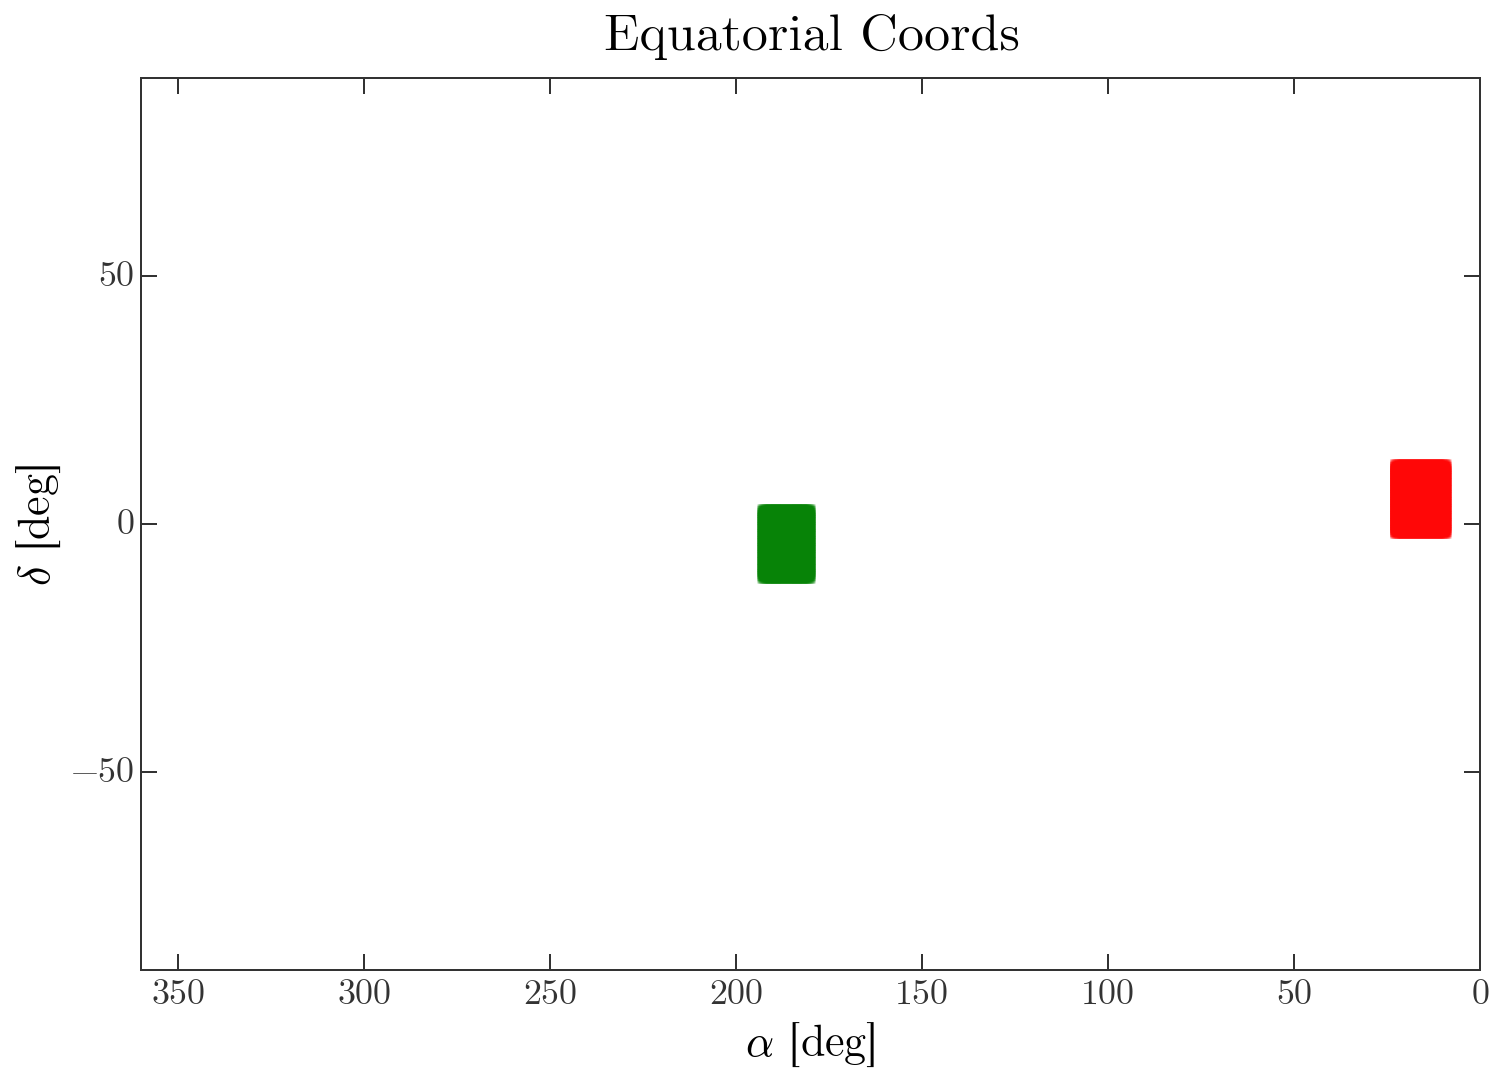

In [96]:
fig = plt.figure(figsize=(12,8))

plt.plot(field8_pts.ra.degree, field8_pts.dec.degree, 
         marker='s', linestyle='none', color='r', alpha=0.1)
plt.plot(field10_pts.ra.degree, field10_pts.dec.degree, 
         marker='s', linestyle='none', color='g', alpha=0.1)

plt.title("Equatorial Coords", y=1.02)
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(360, 0)
plt.ylim(-90, 90)
plt.xlabel(r"$\alpha$ [deg]")
plt.ylabel(r"$\delta$ [deg]")

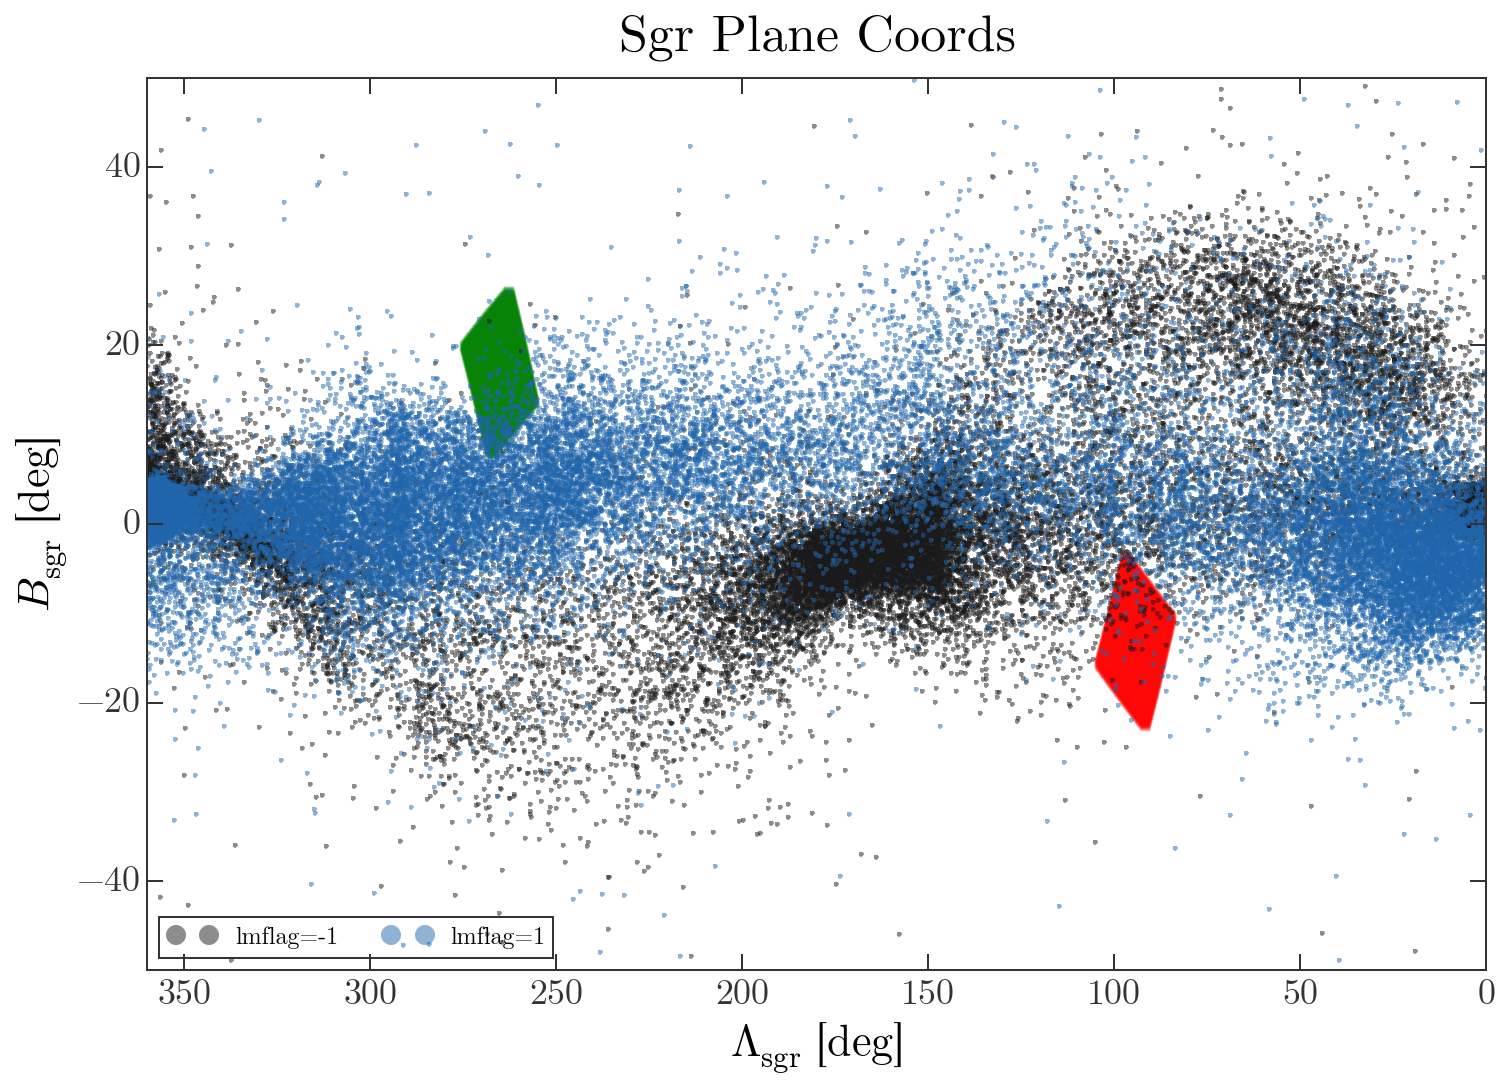

In [89]:
fig = plt.figure(figsize=(12,8))

plt.plot(field8_sgr.Lambda.degree, field8_sgr.Beta.degree, 
         marker='s', linestyle='none', color='r', alpha=0.1)
plt.plot(field10_sgr.Lambda.degree, field10_sgr.Beta.degree, 
         marker='s', linestyle='none', color='g', alpha=0.1)

for lmflag in [-1,1]:
    ix = lm10['Lmflag'] == lmflag
    sc = plt.plot(lm10_sgr.Lambda.degree[ix], lm10_sgr.Beta.degree[ix], 
                  marker='.', linestyle='none', alpha=0.5, label='lmflag={0}'.format(lmflag))

plt.title("Sgr Plane Coords", y=1.02)
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(360, 0)
plt.ylim(-50, 50)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$B_{\rm sgr}$ [deg]")

---

## SDSS F stars

I did a really crude [SQL query on SDSS / SEGUE](http://skyserver.sdss.org/dr12/en/tools/search/sql.aspx) to get F stars in this region. The query was:

```SQL
SELECT st.ra, st.dec, st.psfMag_u, st.psfMag_g, st.psfMag_r, st.psfMag_i, st.psfMag_z, 
       sp.teffadop, sp.fehadop, sp.loggadop, sp.ELODIERVFINAL, sp.ELODIERVFINALerr, sp.snr, sp.flag
FROM specobjall so
JOIN sppparams sp ON so.specobjid = sp.specobjid and so.sciencePrimary=1
JOIN Star st on so.specobjid = st.specobjid
--- F star temperatures because...physics or something...
WHERE sp.teffadop  BETWEEN 6000 and 7600
      AND sp.snr > 20
      AND st.ra BETWEEN 9 and 23 
      AND st.dec BETWEEN -2 and 12
```

Then I repeated for G stars:

```SQL
SELECT st.ra, st.dec, st.psfMag_u, st.psfMag_g, st.psfMag_r, st.psfMag_i, st.psfMag_z, 
       sp.teffadop, sp.fehadop, sp.loggadop, sp.ELODIERVFINAL, sp.ELODIERVFINALerr, sp.snr, sp.flag
FROM specobjall so
JOIN sppparams sp ON so.specobjid = sp.specobjid and so.sciencePrimary=1
JOIN Star st on so.specobjid = st.specobjid
--- G star temperatures because...physics or something...
WHERE sp.teffadop  BETWEEN 5200 and 6000
      AND sp.snr > 20
      AND st.ra BETWEEN 9 and 23 
      AND st.dec BETWEEN -2 and 12
```

In [9]:
sdss_fstars = ascii.read("../data/sdss_f_stars_k2_field8.csv")
print(sdss_fstars.colnames)

['ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'teffadop', 'fehadop', 'loggadop', 'ELODIERVFINAL', 'ELODIERVFINALerr', 'snr', 'flag']


In [10]:
fstars_c = coord.SkyCoord(ra=sdss_fstars['ra'] * u.deg,
                          dec=sdss_fstars['dec'] * u.deg)
fstars_sgr = fstars_c.transform_to(gc.Sagittarius)

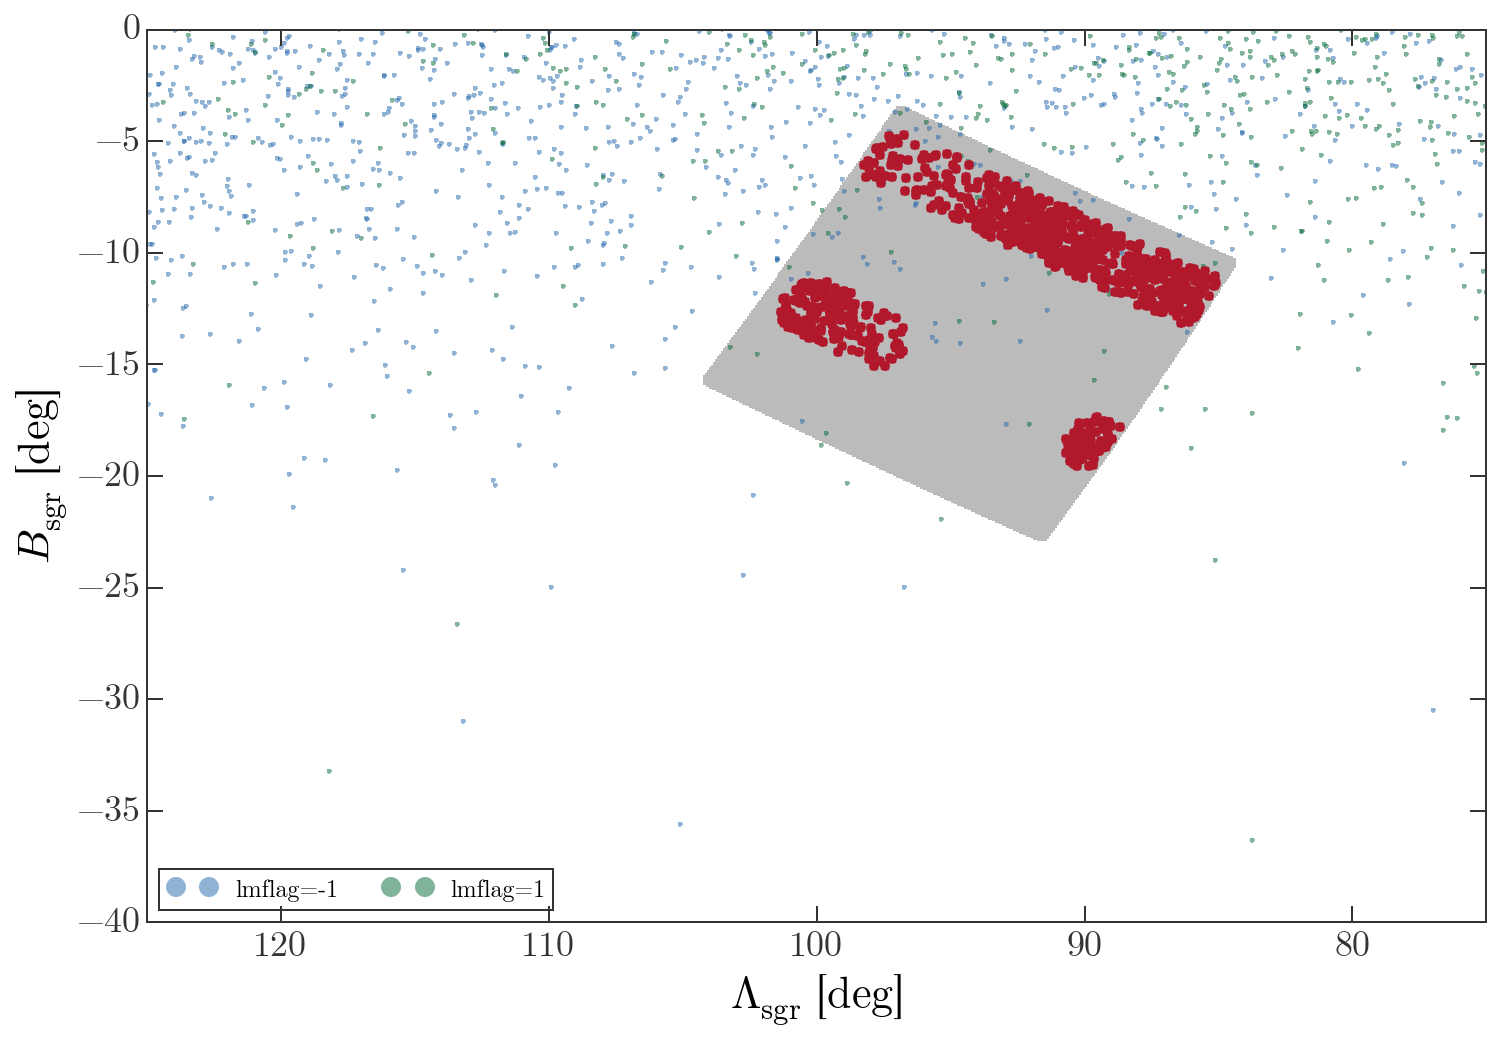

In [11]:
fig = plt.figure(figsize=(12,8))

plt.plot(field8_sgr.Lambda.degree, field8_sgr.Beta.degree, 
         marker='s', linestyle='none', c='#bbbbbb')

for lmflag in [-1,1]:
    ix = lm10['Lmflag'] == lmflag
    sc = plt.plot(lm10_sgr.Lambda.degree[ix], lm10_sgr.Beta.degree[ix], 
                  marker='.', linestyle='none', alpha=0.5, label='lmflag={0}'.format(lmflag))

plt.plot(fstars_sgr.Lambda.degree, fstars_sgr.Beta.degree, 
         marker='o', alpha=1., linestyle='none')
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(125, 75)
plt.ylim(-40, 0)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$B_{\rm sgr}$ [deg]")

Convert the radial velocities to the GSR, to compare to the model

In [12]:
fstars_vgsr = gc.vhel_to_vgsr(fstars_c, sdss_fstars['ELODIERVFINAL']*u.km/u.s)

In [13]:
fstar_mask = (fstars_vgsr.value < 125.) & (fstars_vgsr.value > 50)
fstar_mask = np.ones_like(fstar_mask).astype(bool)

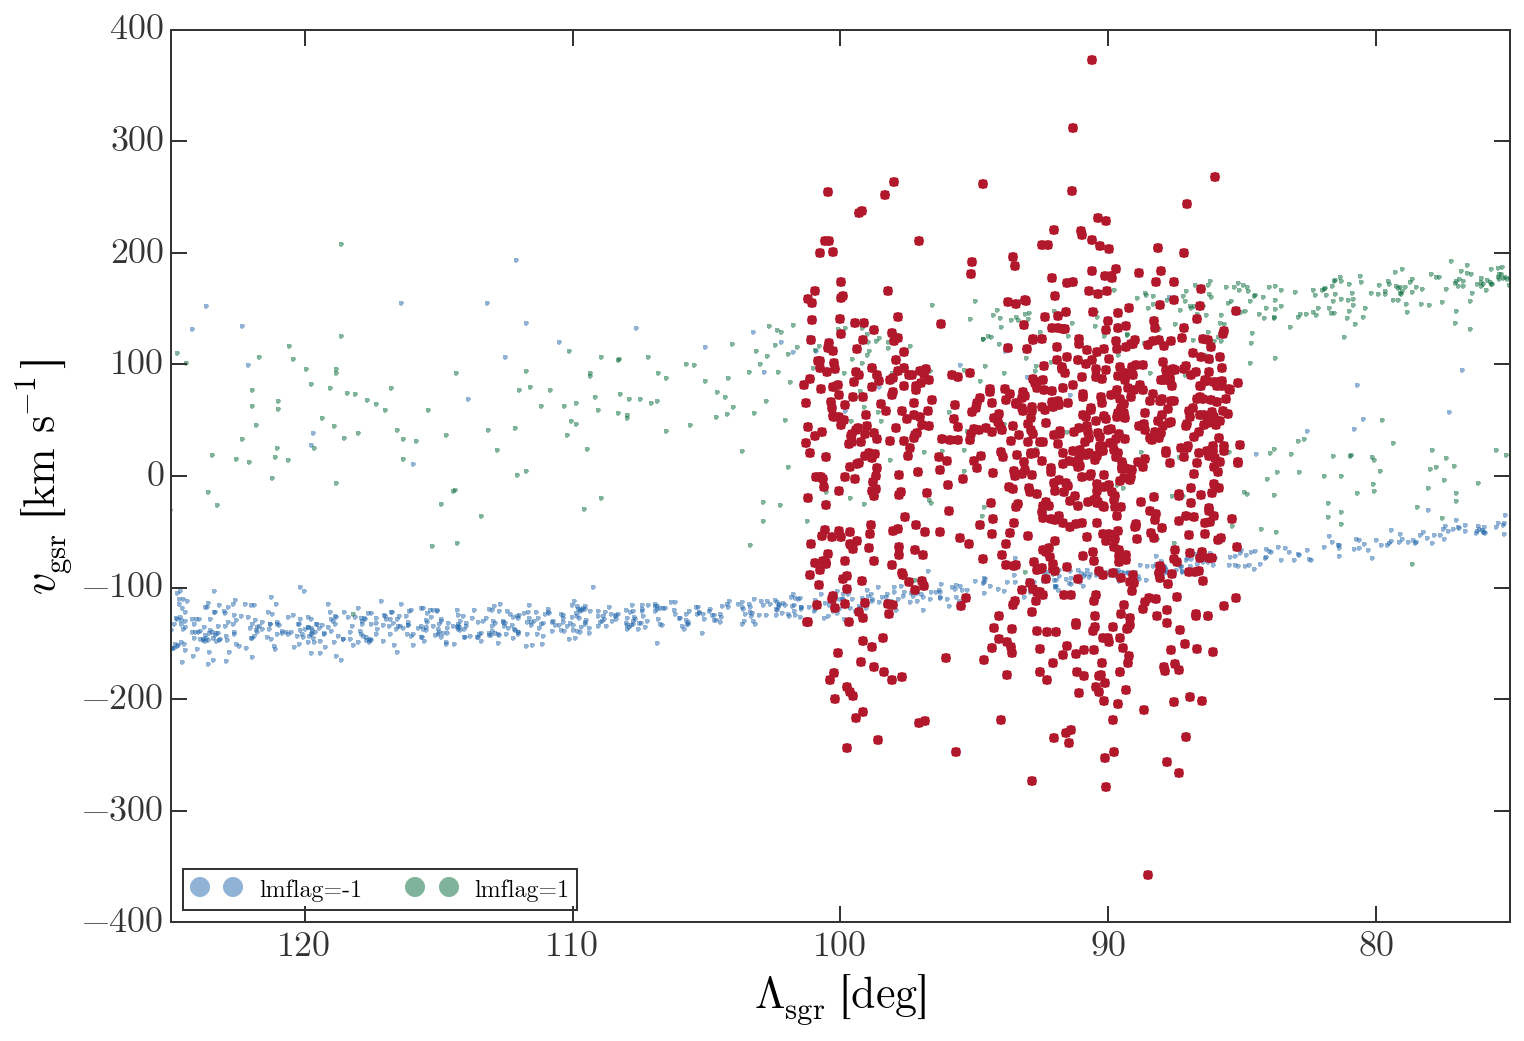

In [14]:
fig = plt.figure(figsize=(12,8))

plt.plot(field8_sgr.Lambda.degree, field8_sgr.Beta.degree*1000, 
         marker='s', linestyle='none', c='#bbbbbb')

for lmflag in [-1,1]:
    ix = (lm10['Lmflag'] == lmflag) & (lm10_sgr.Beta.degree < 0.)
    sc = plt.plot(lm10_sgr.Lambda.degree[ix], lm10['vgsr'][ix], 
                  marker='.', linestyle='none', alpha=0.5, label='lmflag={0}'.format(lmflag))

l, = plt.plot(fstars_sgr.Lambda.degree[fstar_mask], fstars_vgsr.value[fstar_mask], 
              marker='o', alpha=1., linestyle='none')
plt.plot(fstars_sgr.Lambda.degree[~fstar_mask], fstars_vgsr.value[~fstar_mask], 
         marker='o', alpha=0.3, linestyle='none', color=l.get_color())
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(125, 75)
plt.ylim(-400, 400)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$v_{\rm gsr}$ [km s$^{-1}$]")

/Users/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:56: RuntimeWarning: invalid value encountered in greater
/Users/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:56: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:57: RuntimeWarning: invalid value encountered in greater
/Users/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:57: RuntimeWarning: invalid value encountered in less


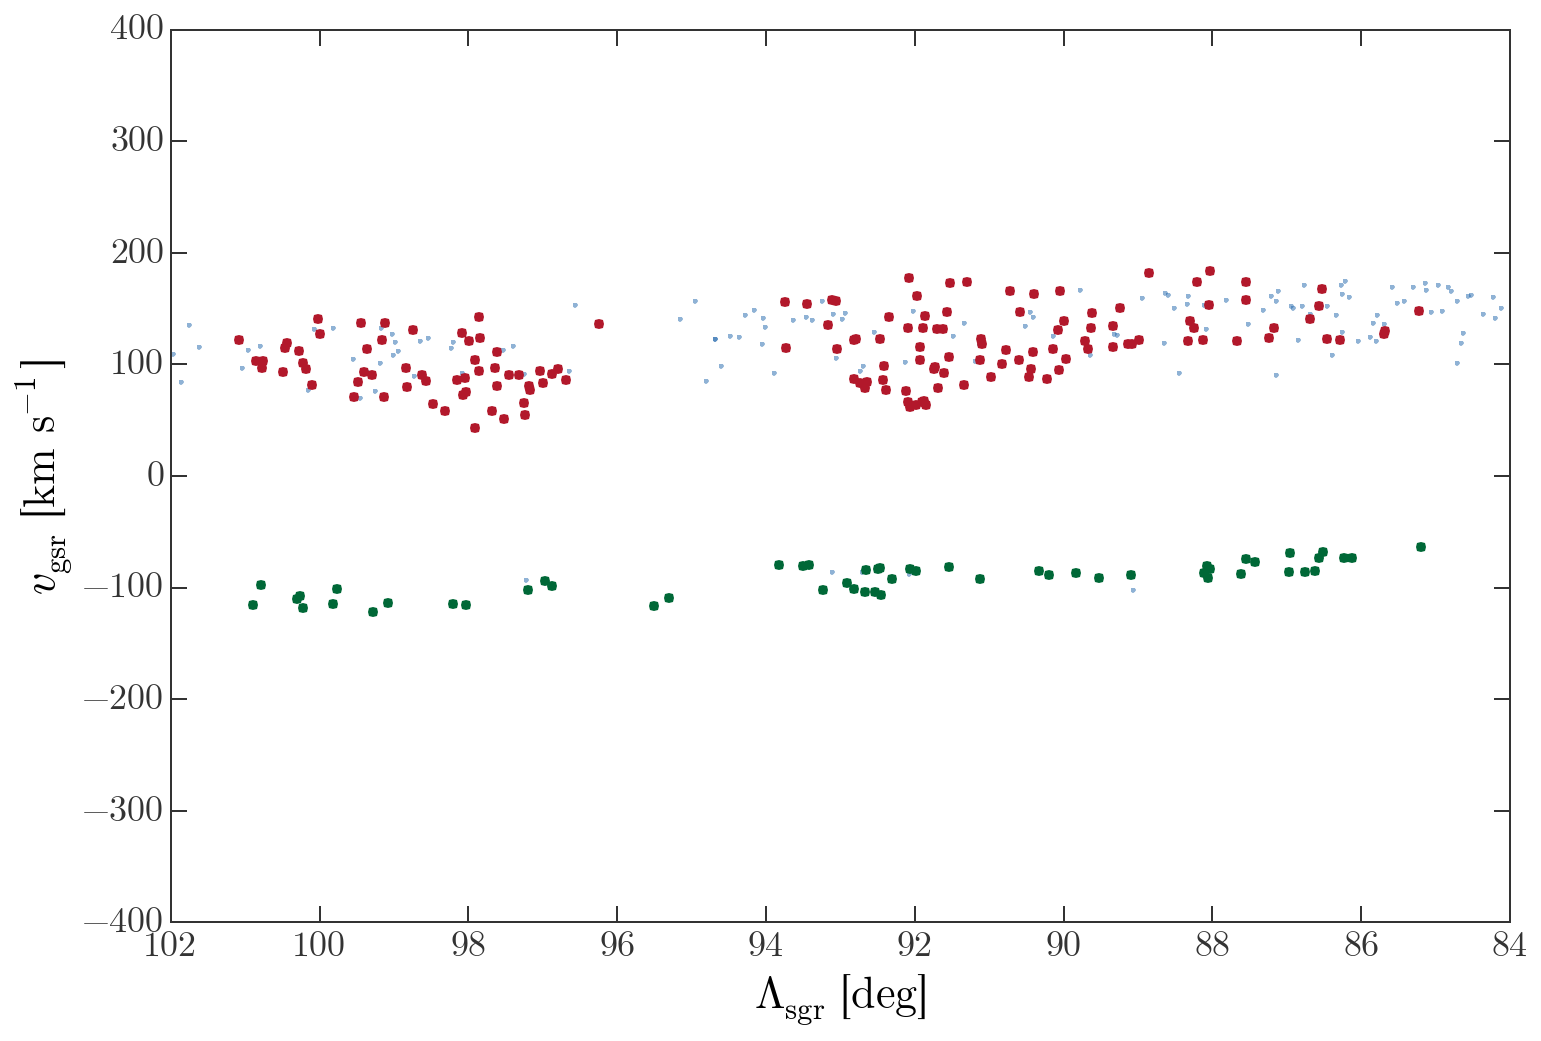

In [74]:
fig = plt.figure(figsize=(12,8))

plt.plot(field8_sgr.Lambda.degree, field8_sgr.Beta.degree*1000, 
         marker='s', linestyle='none', c='#bbbbbb')


ix = (lm10['Lmflag'] == -1) & (lm10_sgr.Beta.degree < 0.)
L = lm10_sgr.Lambda.degree[ix]
vgsr = lm10['vgsr'][ix]

bins = np.linspace(84, 102, 11)
binc = (bins[:-1]+bins[1:])/2.
meds = []
stds = []
for binL,binR in zip(bins[:-1], bins[1:]):
    _ix = (L > binL) & (L < binR)
    _vgsr = vgsr[_ix]
    meds.append(np.median(_vgsr))
    stds.append(mad_std(_vgsr))

med_interp_m1 = interp1d(binc, meds, bounds_error=False)
std_interp_m1 = interp1d(binc, stds, bounds_error=False)

# -- no time to not suck --
ix = (lm10['Lmflag'] == 1) & (lm10_sgr.Beta.degree < 0.) & (lm10['dist'] < 30.)
L = lm10_sgr.Lambda.degree[ix]
vgsr = lm10['vgsr'][ix]

bins = np.linspace(84, 102, 11)
binc = (bins[:-1]+bins[1:])/2.
meds = []
stds = []
for binL,binR in zip(bins[:-1], bins[1:]):
    _ix = (L > binL) & (L < binR)
    _vgsr = vgsr[_ix]
    meds.append(np.median(_vgsr))
    stds.append(mad_std(_vgsr))

med_interp_p1 = interp1d(binc, meds, bounds_error=False)
std_interp_p1 = interp1d(binc, stds, bounds_error=False)

# --

los_m = np.zeros_like(fstars_vgsr.value)
his_m = np.zeros_like(fstars_vgsr.value)
for i,(LL,vv) in enumerate(zip(fstars_sgr.Lambda.degree, fstars_vgsr.value)):
    los_m[i] = med_interp_m1(LL) - 2*std_interp_m1(LL)
    his_m[i] = med_interp_m1(LL) + 2*std_interp_m1(LL)
    
los_p = np.zeros_like(fstars_vgsr.value)
his_p = np.zeros_like(fstars_vgsr.value)
for i,(LL,vv) in enumerate(zip(fstars_sgr.Lambda.degree, fstars_vgsr.value)):
    los_p[i] = med_interp_p1(LL) - 2*std_interp_p1(LL)
    his_p[i] = med_interp_p1(LL) + 2*std_interp_p1(LL)

vgsr_in_stream_ix_m = (fstars_vgsr.value > los_m) & (fstars_vgsr.value < his_m) 
vgsr_in_stream_ix_p = (fstars_vgsr.value > los_p) & (fstars_vgsr.value < his_p)

sc = plt.plot(L, vgsr, marker='.', linestyle='none', alpha=0.5)
l, = plt.plot(fstars_sgr.Lambda.degree[vgsr_in_stream_ix_m], fstars_vgsr.value[vgsr_in_stream_ix_m], 
              marker='o', alpha=1., linestyle='none')
l, = plt.plot(fstars_sgr.Lambda.degree[vgsr_in_stream_ix_p], fstars_vgsr.value[vgsr_in_stream_ix_p], 
              marker='o', alpha=1., linestyle='none')
# plt.plot(fstars_sgr.Lambda.degree[~vgsr_in_stream_ix], fstars_vgsr.value[~vgsr_in_stream_ix], 
#          marker='o', alpha=0.3, linestyle='none', color=l.get_color())

plt.xlim(102, 84)
plt.ylim(-400, 400)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$v_{\rm gsr}$ [km s$^{-1}$]")

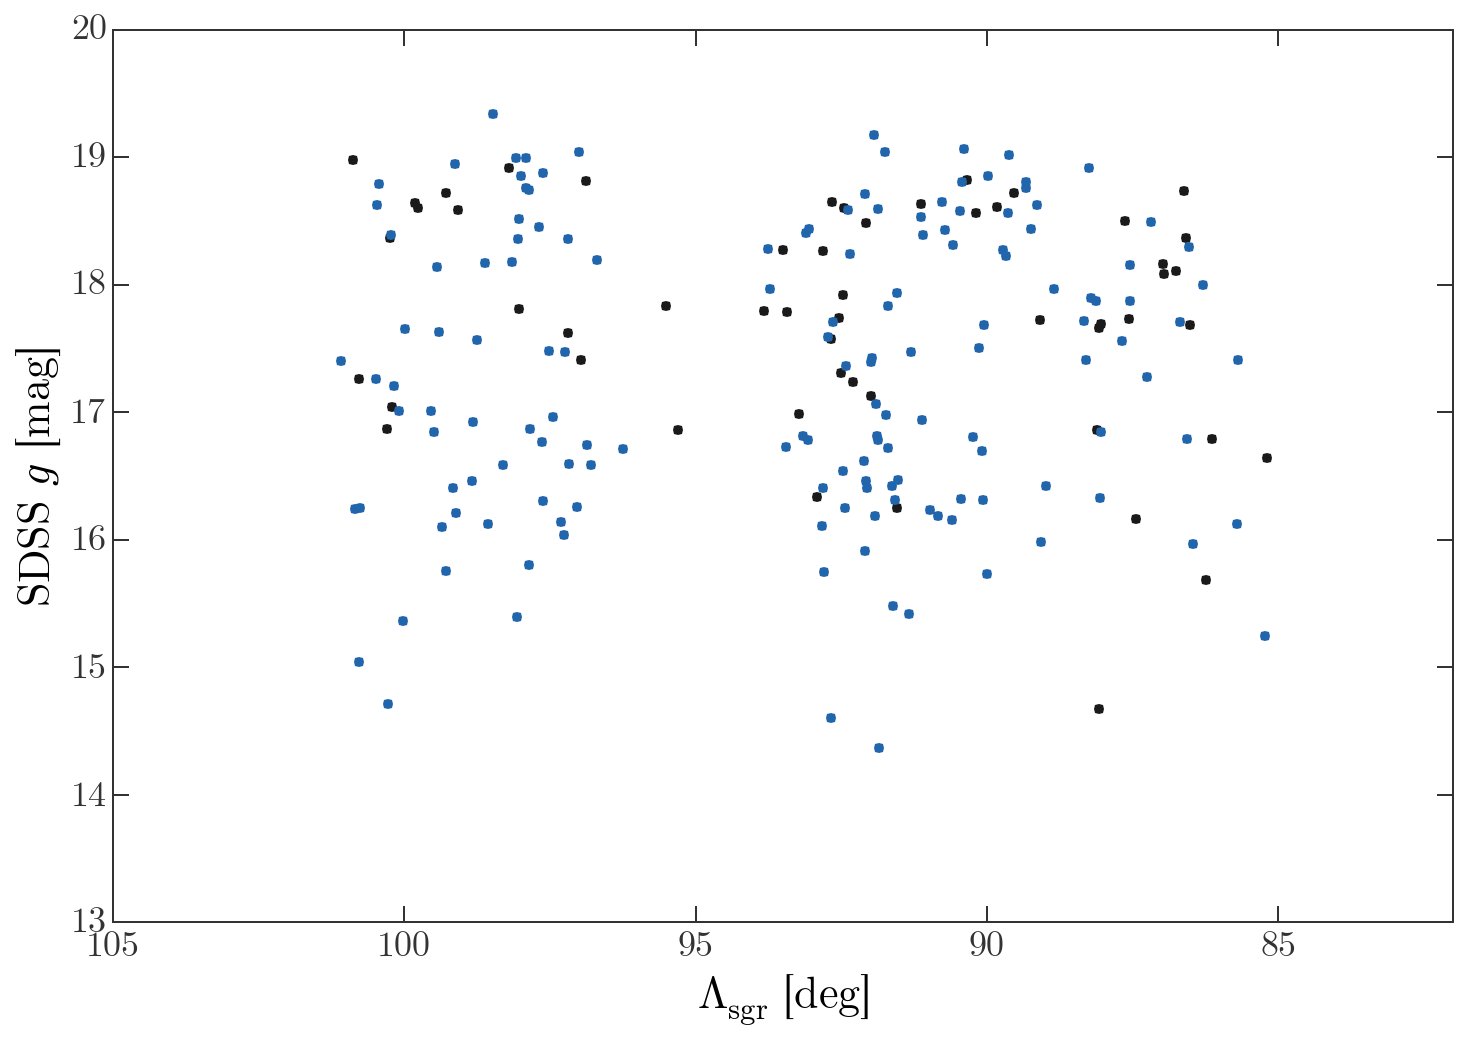

In [75]:
fig = plt.figure(figsize=(12,8))

l, = plt.plot(fstars_sgr.Lambda.degree[vgsr_in_stream_ix_m], sdss_fstars['psfMag_g'][vgsr_in_stream_ix_m],
              marker='o', alpha=1., linestyle='none')
l, = plt.plot(fstars_sgr.Lambda.degree[vgsr_in_stream_ix_p], sdss_fstars['psfMag_g'][vgsr_in_stream_ix_p],
              marker='o', alpha=1., linestyle='none')
# plt.plot(fstars_sgr.Lambda.degree[~vgsr_in_stream_ix], sdss_fstars['psfMag_g'][~vgsr_in_stream_ix],
#          marker='o', alpha=0.3, linestyle='none', color=l.get_color())
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(105, 82)
plt.ylim(13, 20)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"SDSS $g$ [mag]")

Turning magnitudes into distances...

In [65]:
from gary.observation import distance

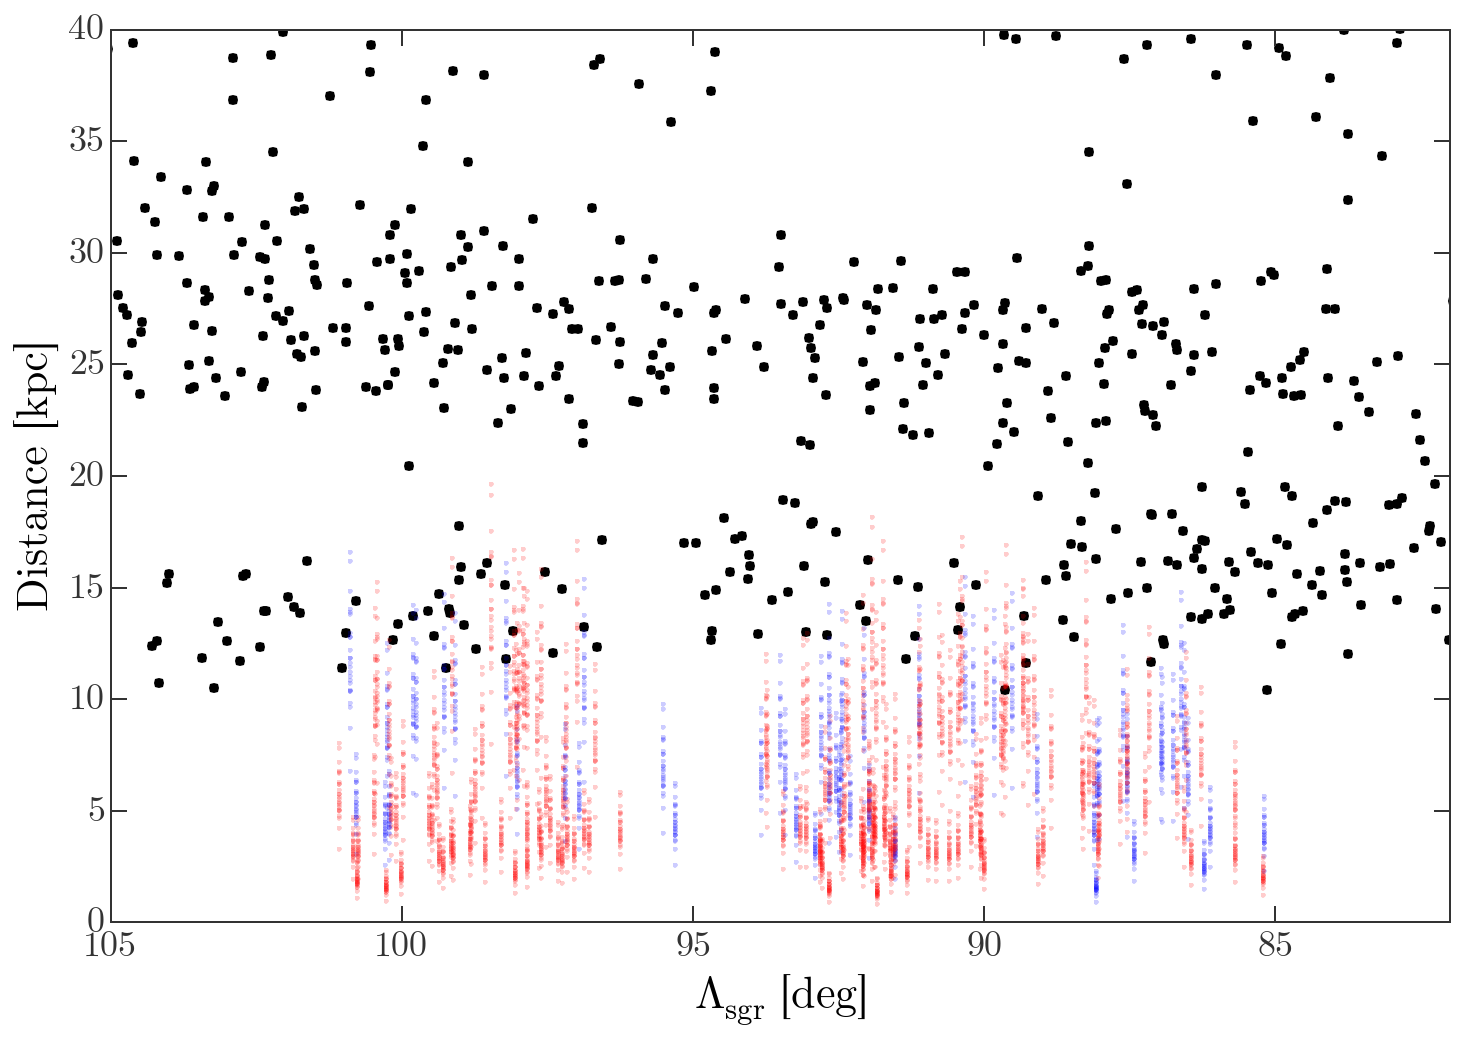

In [77]:
fig = plt.figure(figsize=(12,8))

# ix = (lm10['Lmflag'] == -1) & (lm10_sgr.Beta.degree < 0.)
ix = (lm10_sgr.Beta.degree < 0.)
plt.plot(lm10_sgr.Lambda.degree[ix], lm10['dist'][ix], color='k', alpha=1., marker='o', linestyle='none')

for Mg in np.random.normal(3.5, 0.5, size=25):
    d = distance(sdss_fstars['psfMag_g'] - Mg).to(u.kpc).value
    l, = plt.plot(fstars_sgr.Lambda.degree[vgsr_in_stream_ix_m], d[vgsr_in_stream_ix_m],
                  marker='.', alpha=0.2, linestyle='none', color='b')
    l, = plt.plot(fstars_sgr.Lambda.degree[vgsr_in_stream_ix_p], d[vgsr_in_stream_ix_p],
                  marker='.', alpha=0.2, linestyle='none', color='r')
# plt.plot(fstars_sgr.Lambda.degree[~vgsr_in_stream_ix], d[~vgsr_in_stream_ix],
#          marker='o', alpha=0.1, linestyle='none', color=l.get_color())
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(105, 82)
plt.ylim(0, 40)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"Distance [kpc]")

## G stars

In [3]:
sdss_gstars = ascii.read("../data/sdss_g_stars_k2_field8.csv")
print(sdss_gstars.colnames)

['ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'teffadop', 'fehadop', 'loggadop', 'ELODIERVFINAL', 'ELODIERVFINALerr', 'snr', 'flag']


In [4]:
gstars_c = coord.SkyCoord(ra=sdss_gstars['ra'] * u.deg,
                          dec=sdss_gstars['dec'] * u.deg)
gstars_sgr = gstars_c.transform_to(gc.Sagittarius)
gstars_vgsr = gc.vhel_to_vgsr(gstars_c, sdss_gstars['ELODIERVFINAL']*u.km/u.s)

In [5]:
fig = plt.figure(figsize=(12,8))

plt.plot(field8_sgr.Lambda.degree, field8_sgr.Beta.degree, 
         marker='s', linestyle='none', c='#bbbbbb')

for lmflag in [-1,1]:
    ix = lm10['Lmflag'] == lmflag
    sc = plt.plot(lm10_sgr.Lambda.degree[ix], lm10_sgr.Beta.degree[ix], 
                  marker='.', linestyle='none', alpha=0.5, label='lmflag={0}'.format(lmflag))

plt.plot(gstars_sgr.Lambda.degree, gstars_sgr.Beta.degree, 
         marker='o', alpha=1., linestyle='none')
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(125, 75)
plt.ylim(-40, 0)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$B_{\rm sgr}$ [deg]")

NameError: name 'field_sgr' is not defined

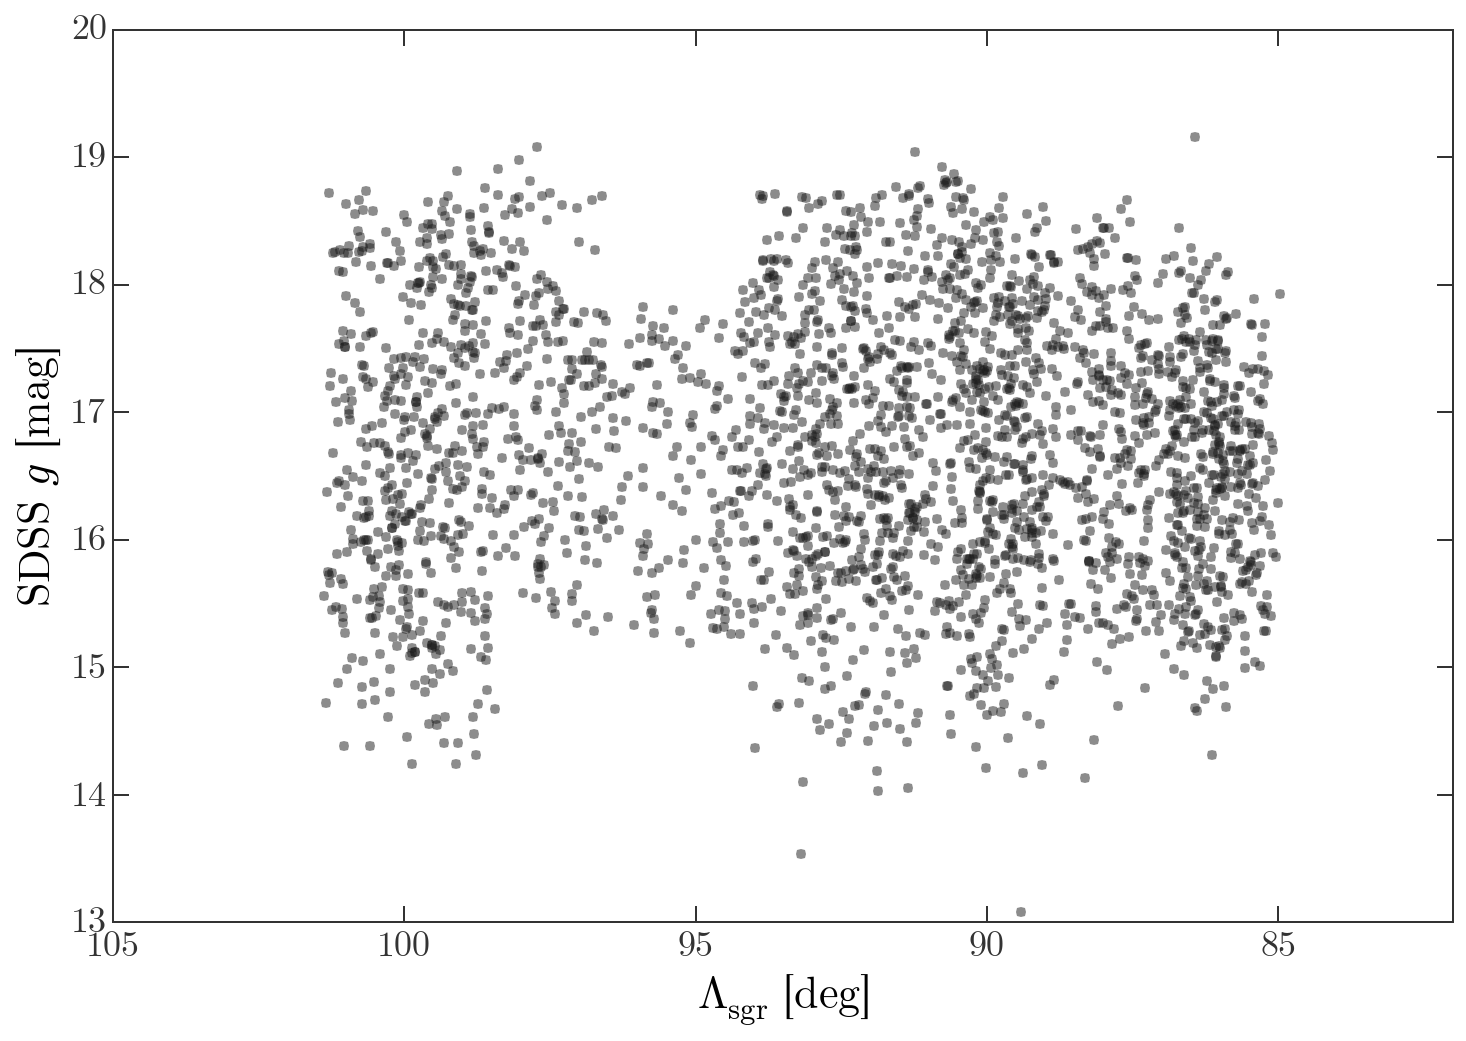

In [11]:
fig = plt.figure(figsize=(12,8))

l, = plt.plot(gstars_sgr.Lambda.degree, sdss_gstars['psfMag_r'],
              marker='o', alpha=0.5, linestyle='none')
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(105, 82)
plt.ylim(13, 20)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"SDSS $g$ [mag]")

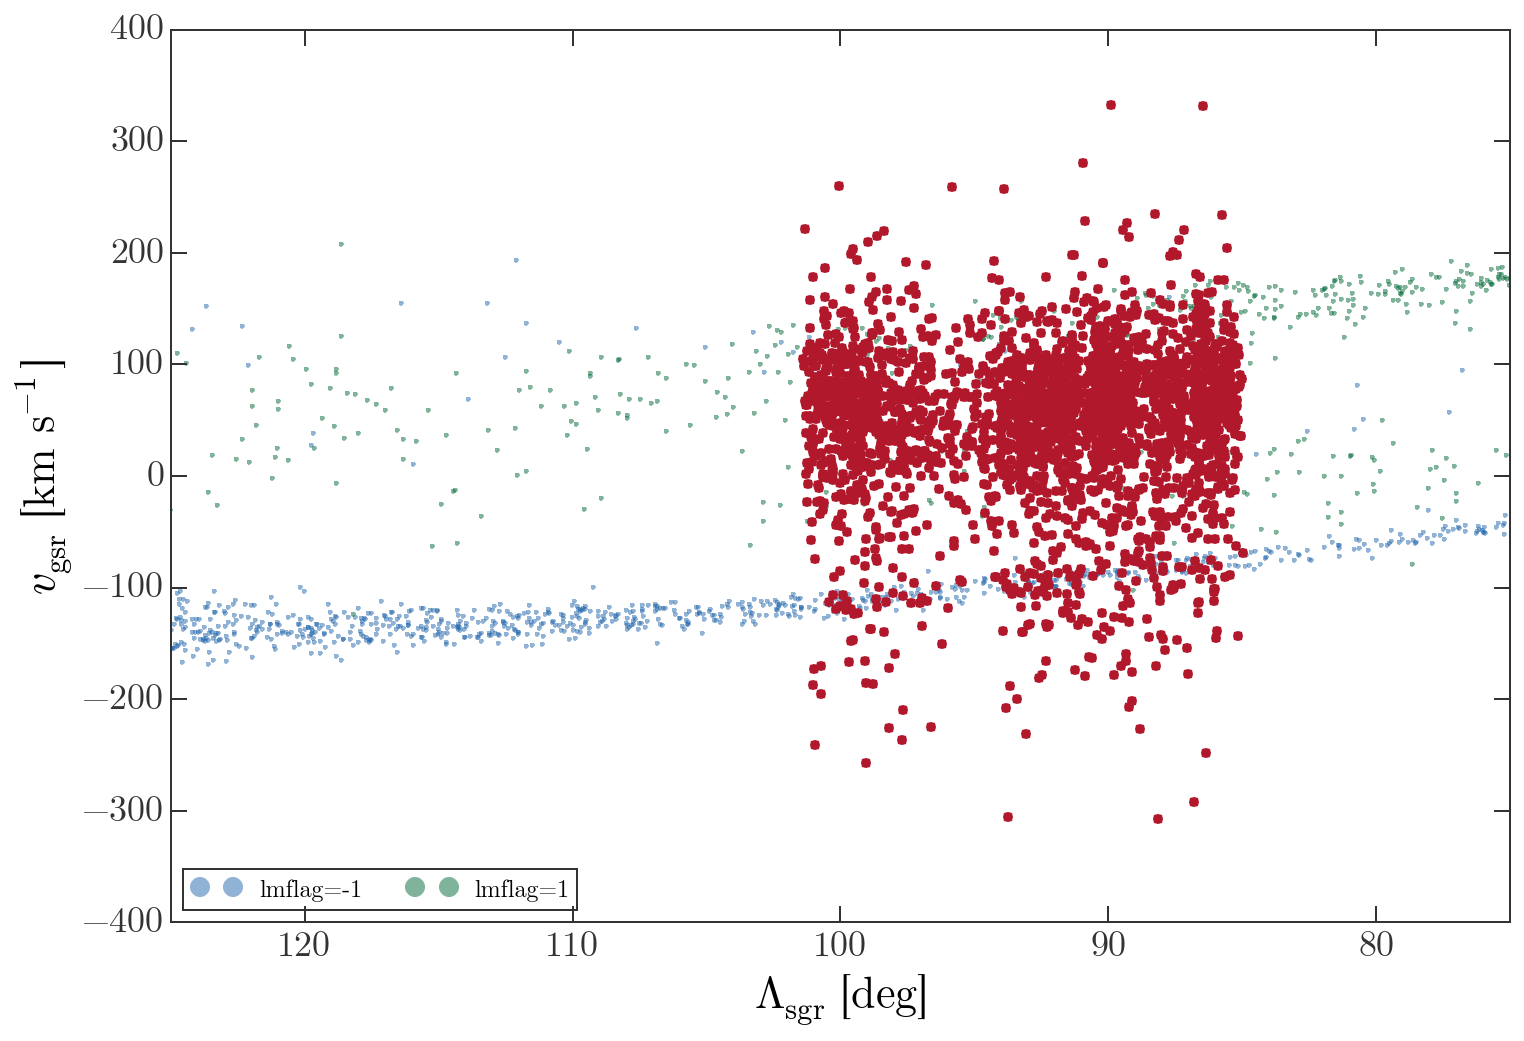

In [13]:
fig = plt.figure(figsize=(12,8))

plt.plot(field8_sgr.Lambda.degree, field8_sgr.Beta.degree*1000, 
         marker='s', linestyle='none', c='#bbbbbb')

for lmflag in [-1,1]:
    ix = (lm10['Lmflag'] == lmflag) & (lm10_sgr.Beta.degree < 0.)
    sc = plt.plot(lm10_sgr.Lambda.degree[ix], lm10['vgsr'][ix], 
                  marker='.', linestyle='none', alpha=0.5, label='lmflag={0}'.format(lmflag))

l, = plt.plot(gstars_sgr.Lambda.degree, gstars_vgsr.value, 
              marker='o', alpha=1., linestyle='none')
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(125, 75)
plt.ylim(-400, 400)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$v_{\rm gsr}$ [km s$^{-1}$]")

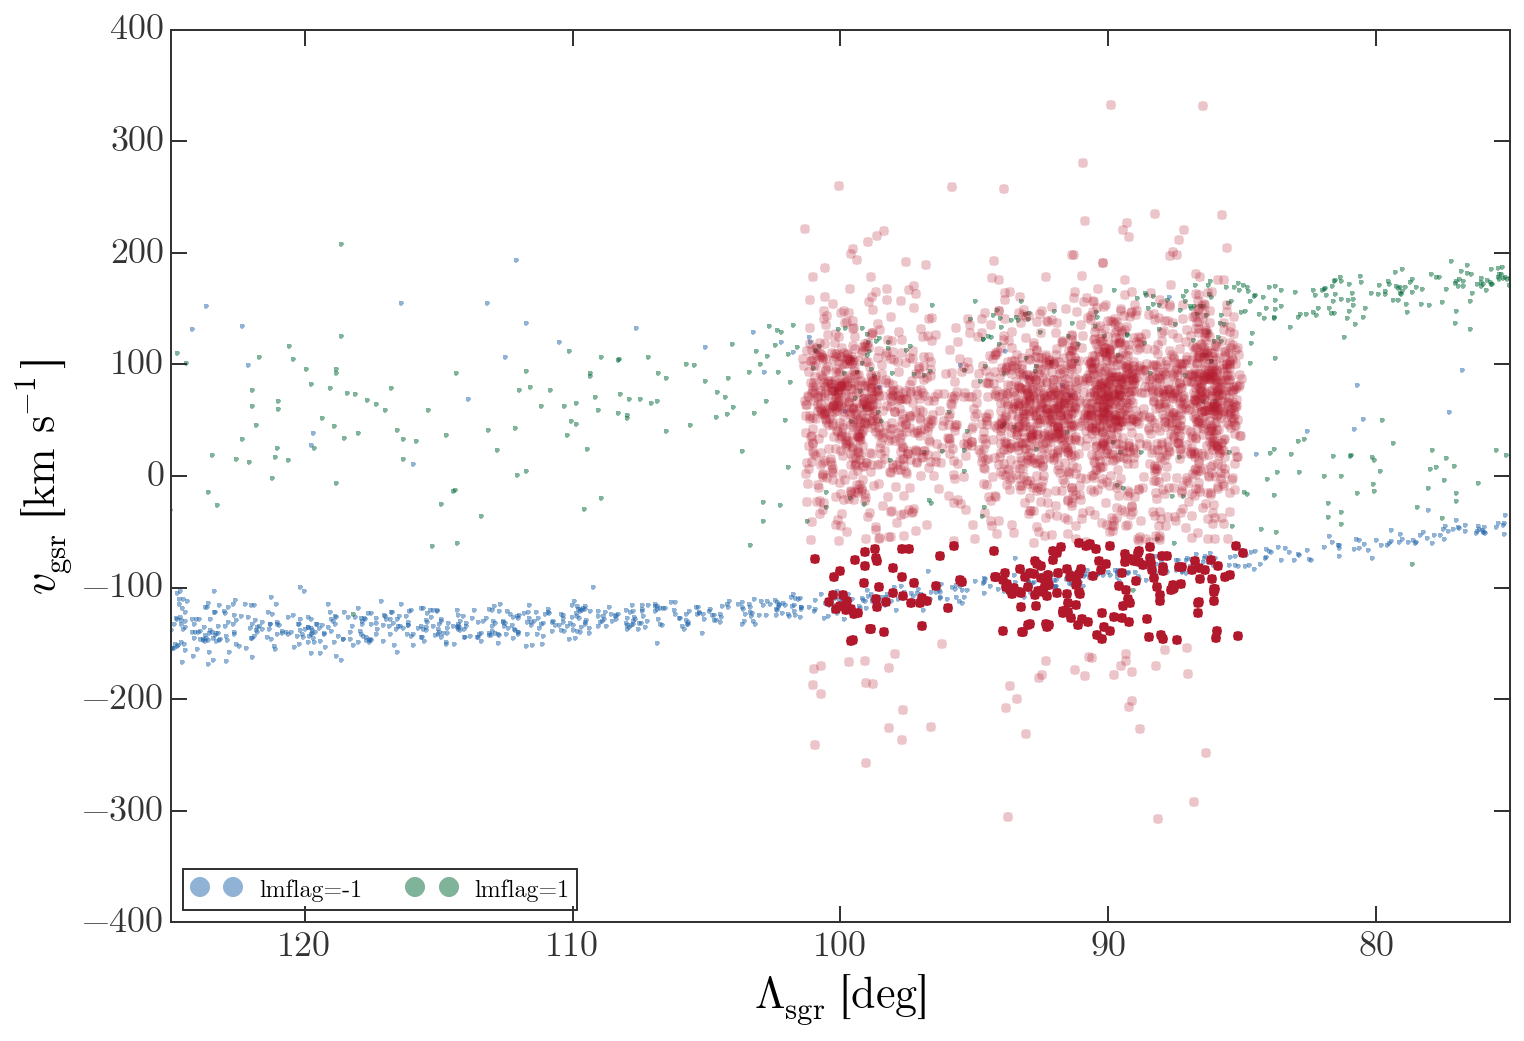

In [19]:
mask = (gstars_vgsr < -60*u.km/u.s) & (gstars_vgsr > -150*u.km/u.s)

fig = plt.figure(figsize=(12,8))

plt.plot(field8_sgr.Lambda.degree, field8_sgr.Beta.degree*1000, 
         marker='s', linestyle='none', c='#bbbbbb')

for lmflag in [-1,1]:
    ix = (lm10['Lmflag'] == lmflag) & (lm10_sgr.Beta.degree < 0.)
    sc = plt.plot(lm10_sgr.Lambda.degree[ix], lm10['vgsr'][ix], 
                  marker='.', linestyle='none', alpha=0.5, label='lmflag={0}'.format(lmflag))

l, = plt.plot(gstars_sgr.Lambda.degree[mask], gstars_vgsr.value[mask], 
              marker='o', alpha=1., linestyle='none')
l, = plt.plot(gstars_sgr.Lambda.degree[~mask], gstars_vgsr.value[~mask], 
              marker='o', alpha=0.25, linestyle='none', color=l.get_color())
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(125, 75)
plt.ylim(-400, 400)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$v_{\rm gsr}$ [km s$^{-1}$]")

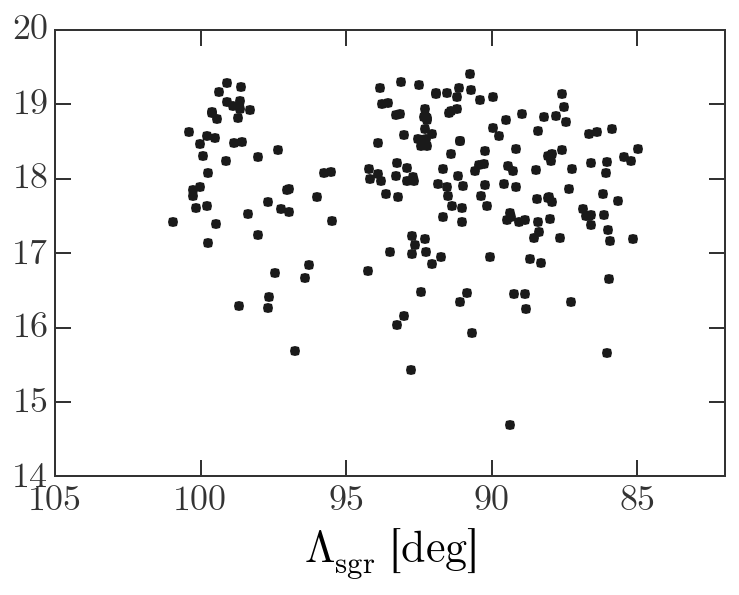

In [31]:
l, = plt.plot(gstars_sgr.Lambda.degree[mask], sdss_gstars['psfMag_g'][mask], 
              marker='o', alpha=1., linestyle='none')
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(105, 82)
# plt.ylim(-200, 0)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
# plt.ylabel(r"$v_{\rm gsr}$ [km s$^{-1}$]")

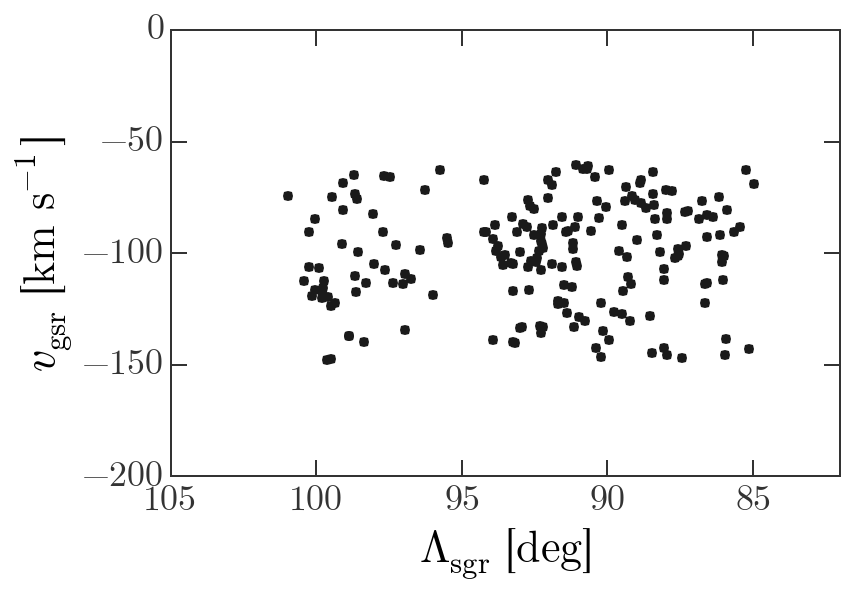

In [21]:
l, = plt.plot(gstars_sgr.Lambda.degree[mask], gstars_vgsr.value[mask], 
              marker='o', alpha=1., linestyle='none')
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(105, 82)
plt.ylim(-200, 0)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$v_{\rm gsr}$ [km s$^{-1}$]")

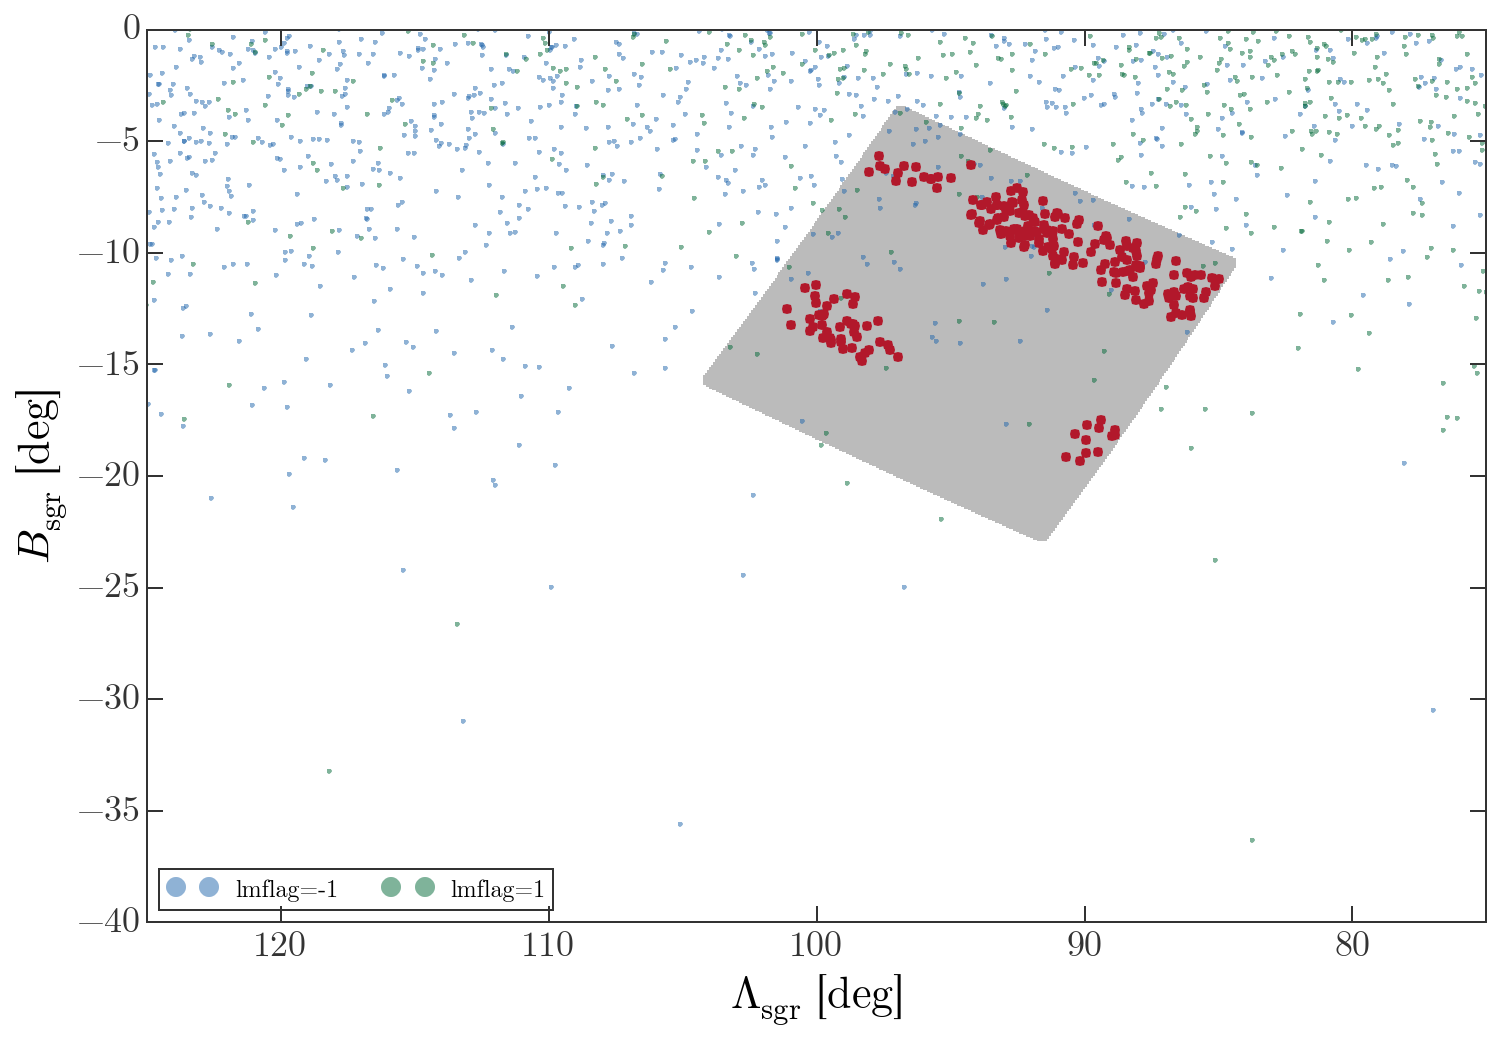

In [18]:
fig = plt.figure(figsize=(12,8))

plt.plot(field8_sgr.Lambda.degree, field8_sgr.Beta.degree, 
         marker='s', linestyle='none', c='#bbbbbb')

for lmflag in [-1,1]:
    ix = lm10['Lmflag'] == lmflag
    sc = plt.plot(lm10_sgr.Lambda.degree[ix], lm10_sgr.Beta.degree[ix], 
                  marker='.', linestyle='none', alpha=0.5, label='lmflag={0}'.format(lmflag))

l, = plt.plot(gstars_sgr.Lambda.degree[mask], gstars_sgr.Beta.degree[mask],
              marker='o', alpha=1., linestyle='none')
# l, = plt.plot(gstars_sgr.Lambda.degree[~mask], gstars_sgr.Beta.degree[~mask],
#               marker='o', alpha=0.25, linestyle='none', color=l.get_color())
    
plt.legend(ncol=2, loc='lower left', markerscale=4)
plt.xlim(125, 75)
plt.ylim(-40, 0)
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"$B_{\rm sgr}$ [deg]")

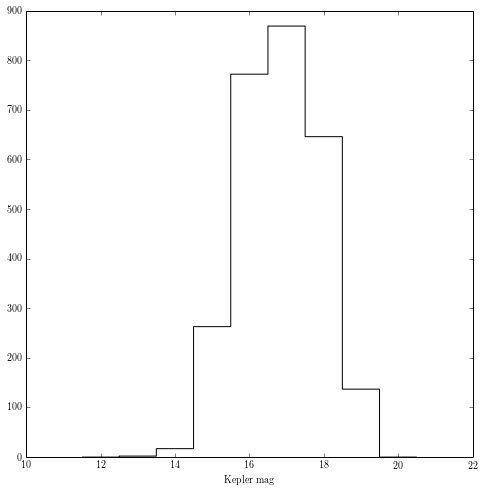

In [21]:
# Compute the approximate Kepler magnitude.
g = sdss_gstars['psfMag_g']
r = sdss_gstars['psfMag_r']
kp = 0.2 * g + 0.8 * r
m = g-r > 0.8
kp[m] = 0.1 * g[m] + 0.9 * r[m]

# Plot the Kepler magnitudes.
plt.figure(figsize=(8, 8))
bins = np.arange(11.5, 21, 1)
plt.hist(kp, bins, histtype="step", color="k")
plt.xlabel("Kepler mag");

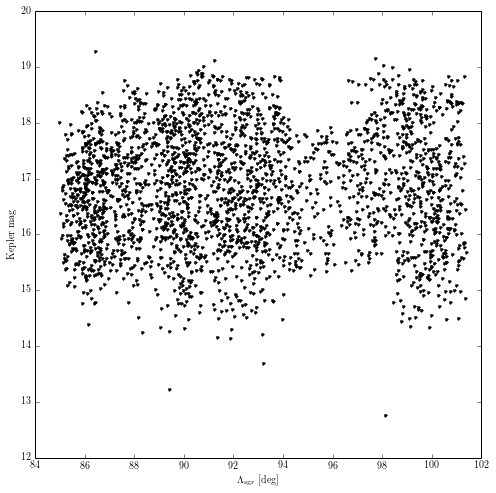

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(gstars_sgr.Lambda.degree, kp, ".k")
plt.xlabel(r"$\Lambda_{\rm sgr}$ [deg]")
plt.ylabel(r"Kepler mag");

In [22]:
gstars_sgr.Lambda.degree

array([  95.95107548,   94.15765727,   95.72923376, ...,   99.62951724,
        100.42600443,  100.13060393])